Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000

Visualizing random training images:


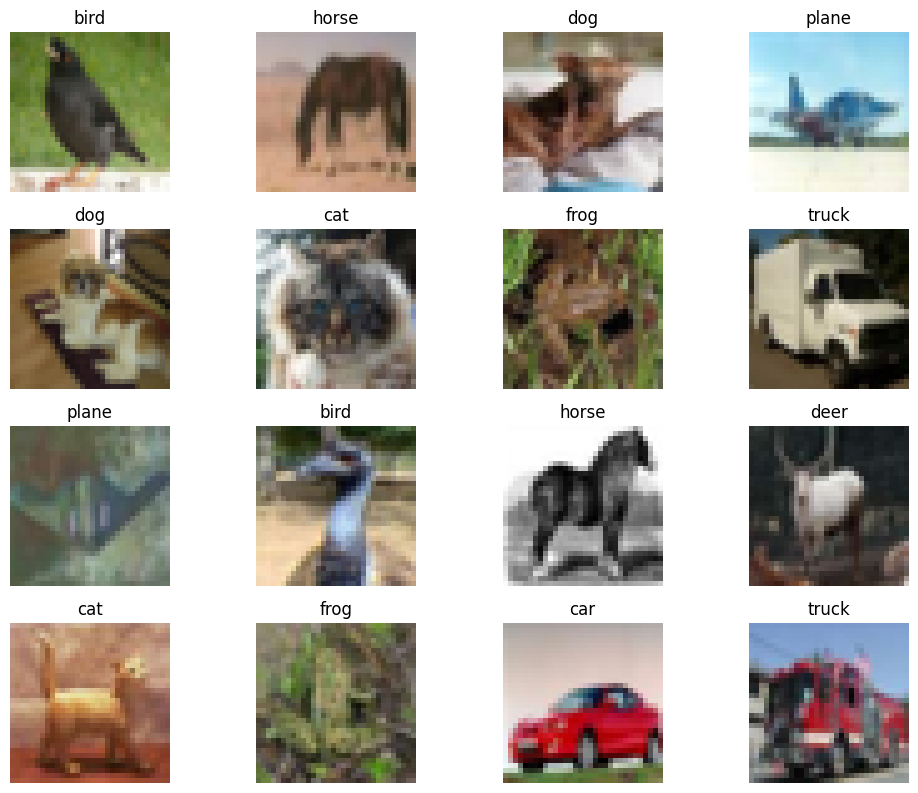

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Download and Load Data
# We download both Train and Test sets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# 2. Setup Visualization
# CIFAR-10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

def show_grid(dataset, num_images=16, cols=4):
    """
    Plots a grid of images from the dataset with their labels.
    """
    fig = plt.figure(figsize=(10, 10))
    
    # Randomly select indices
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        image, label_idx = dataset[idx] # dataset returns (PIL Image, label_index)
        
        ax = fig.add_subplot(num_images // cols + 1, cols, i + 1)
        ax.imshow(image)
        ax.set_title(classes[label_idx])
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# 3. Visualize
print("\nVisualizing random training images:")
show_grid(train_dataset)

Files already downloaded and verified

--- Class List ---
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


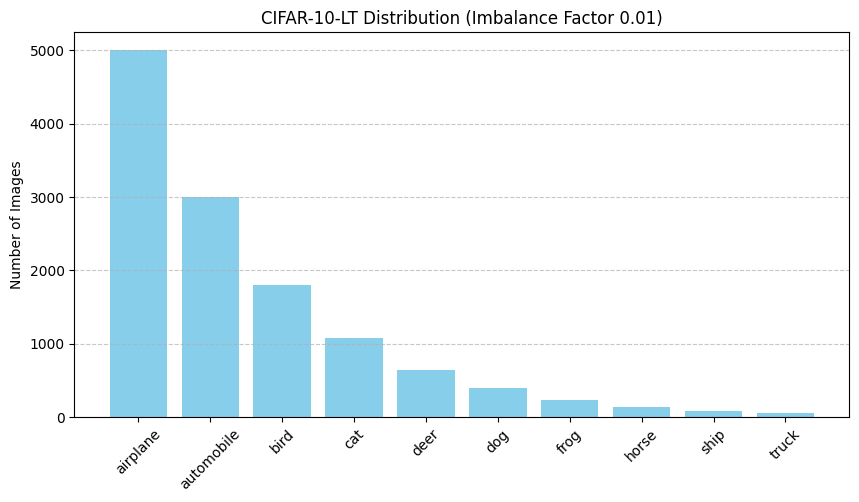


--- Sample Images ---
Total dataset size: 12406


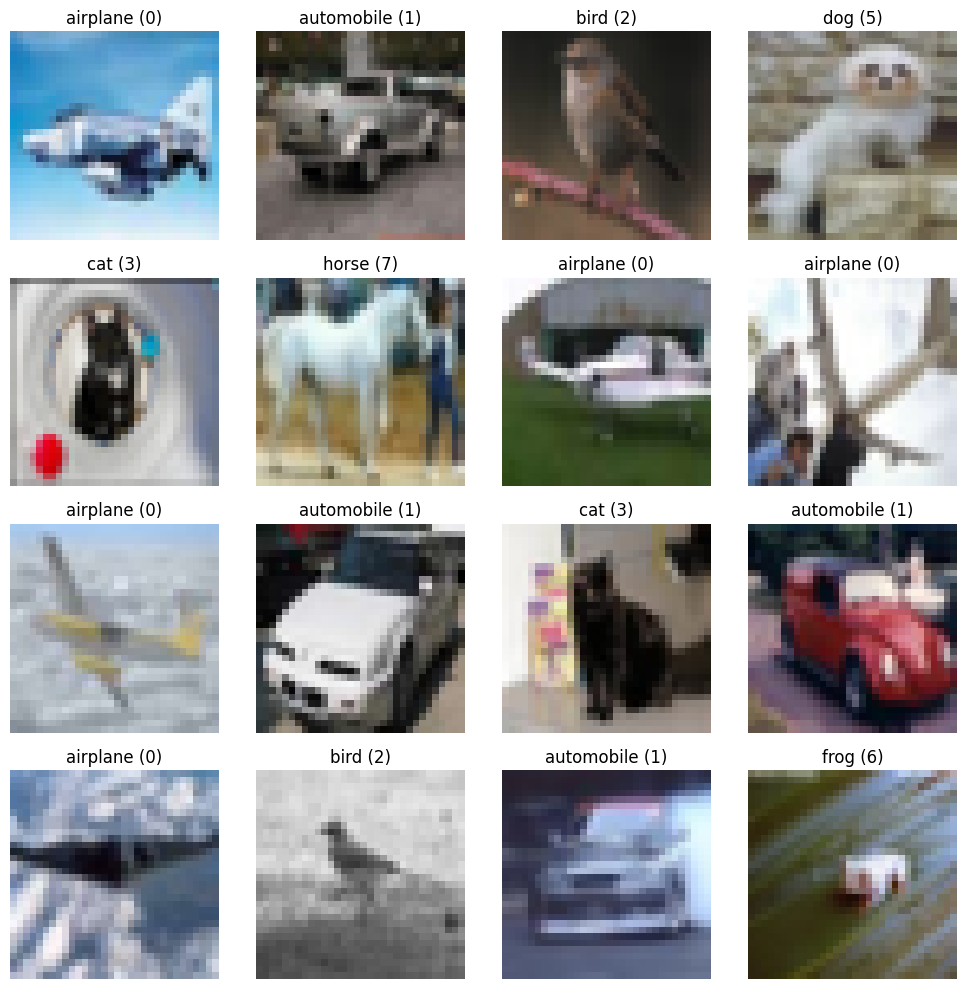

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Define the Imbalanced Dataset Class ---
class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    """
    CIFAR-10 dataset that creates a Long-Tailed distribution.
    Inherits from the standard torchvision CIFAR10 class.
    """
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None, download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        
        if train:
            np.random.seed(rand_number)
            img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
            self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            max_num = img_max
            min_num = img_max * imb_factor
            for cls_idx in range(cls_num):
                if cls_idx < cls_num // 2:
                    img_num_per_cls.append(int(max_num))
                else:
                    img_num_per_cls.append(int(min_num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        
        self.num_per_cls_dict = dict()
        
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
            
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

# --- 2. Main Execution ---
if __name__ == "__main__":
    
    # Configuration
    DATA_ROOT = './data'
    IMB_FACTOR = 0.01  # 100:1 ratio (Head class ~5000, Tail class ~50)

    # CIFAR-10 Class Names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    print(f"Downloading and creating CIFAR-10-LT (Factor: {IMB_FACTOR})...")
    
    # Create Dataset (No transforms, so we get PIL images for easy plotting)
    dataset = IMBALANCECIFAR10(
        root=DATA_ROOT,
        imb_type='exp',
        imb_factor=IMB_FACTOR,
        train=True,
        download=True
    )

    # --- Print Class List ---
    print("\n--- Class List ---")
    for i, name in enumerate(class_names):
        print(f"Class {i}: {name}")

    # --- Visualize Distribution (Bar Chart) ---
    counts = dataset.get_cls_num_list()
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f'CIFAR-10-LT Distribution (Imbalance Factor {IMB_FACTOR})')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\n--- Sample Images ---")
    print(f"Total dataset size: {len(dataset)}")

    # --- Visualize Sample Images (Grid) ---
    # We pick random images to show
    num_images = 16
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    fig = plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        img, label_idx = dataset[idx] # Returns PIL Image, Label Index
        
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(img)
        ax.set_title(f"{class_names[label_idx]} ({label_idx})")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()